In [7]:
%matplotlib inline

import numpy as np
import collections
from collections import OrderedDict, Counter, defaultdict
import pandas as pd

import Bio
from Bio import SeqIO

import seaborn as sns
import matplotlib.pyplot as plt
from bokeh.plotting import figure, output_file, show 
import matplotlib.patches as patches    
from matplotlib import colors


import glob

import subprocess
from subprocess import call

import re

import pickle

from Bio.SubsMat import MatrixInfo
import Bio.Data.CodonTable

from scipy import stats


from Bio.SubsMat import MatrixInfo
import Bio.Data.CodonTable

import joypy

# Metadata, RiboSET_ext

In [11]:
metadata_pc_g25 = pd.read_csv('../../tmp_res/metadata_pc_g25.txt', sep='\t')
meta = pd.read_csv('../../tmp_res/local_and_global_df_g25ovlp_g35ovlp_g38ovlp_refseqovlp_strand_FRAMES_PhyloCSF.txt', sep='\t')

In [12]:
# open SET1 (PhyloSET) and SET2 (RiboSET)
PhyloSET = pd.read_csv('../../tmp_res/SET1.txt', sep='\t')

RiboSET = pd.read_csv('../../tmp_res/SET2.txt', sep='\t')
RiboSET['tr_id1'] = [x.split('.')[0] for x in RiboSET['tr_id'].tolist()]
RiboSET = RiboSET[(~RiboSET['Riboseq_Summary'].str.contains('ATG')) & 
                  (~RiboSET['tr_id'].str.contains('PAR'))]
print (RiboSET.shape[0])

390


In [13]:
RiboSET_EXT_cds_cov_nonzero = pd.read_csv('FINAL_RiboSET_EXT_cds_cov_nonzero_theor_len_20codons_3532genes.txt', 
                                  sep='\t')


print (RiboSET_EXT_cds_cov_nonzero.shape[0])
RiboSET_EXT_cds_cov_nonzero[0:2]

3451


,tr_id1,Z_score,CDS_coverage,NTE_coverage,CDS_nonzero_fraction,NTE_nonzero_fraction,gene_ext,Start_ext,Stop_ext,global_rank_ext,...,max_sum_overlap_g38_all_exons_strandless,max_sum_overlap_refseq_all_exons,max_sum_overlap_refseq_all_exons_strandless,ovlp,ovlp_strandless,ovlp2,ovlp2_strandless,PhyloCSF120score,number_of_records,records_names
0,ENST00000379454,0.032101,298.318841,317.934783,0.332894,0.260870,ASPH,144,189,1,...,0,0,0,0;0;0,0;0;0,0;0;0;0,0;0;0;0,-1473.5792,93,Human; Chimp; Bonobo; Gorilla; Orangutan; Gibb...
1,ENST00000216281,0.139750,195.778990,441.650000,0.158709,0.194444,HSP90AA1,168,207,2,...,0,0,0,0;0;0,0;0;0,0;0;0;0,0;0;0;0,-1331.1851,63,Human; Chimp; Gorilla; Orangutan; Gibbon; Crab...


# TIS scores 

In [8]:
TIS_efficiency_df = pd.read_csv('../../data/TIS_nonAUG_efficiency.txt', sep='\t')

TIS_efficiency_df['scaled_efficiency'] = TIS_efficiency_df['TIS Efficiency'] / TIS_efficiency_df['TIS Efficiency'].max()

TIS_efficiency_dict = dict(zip(TIS_efficiency_df['TIS Sequence'], TIS_efficiency_df['TIS Efficiency']))

TIS_efficiency_dict_scaled = dict(zip(TIS_efficiency_df['TIS Sequence'], TIS_efficiency_df['scaled_efficiency']))

TIS_efficiency_df.sort_values(by='TIS Efficiency', ascending=False).head(4)

,TIS Sequence,TIS Efficiency,scaled_efficiency
5977,CGCCCUGG,50.4,1.000000
6041,CGCGCUGG,50.4,1.000000
5913,CGCACUGG,50.4,1.000000
6001,CAUCCUGG,47.6,0.944444


In [9]:
TIS_AUG_eff = pd.read_csv('../../data/TIS_AUG_efficiency.txt', sep='\t')

TIS_AUG_eff['scaled_efficiency'] = TIS_AUG_eff['efficiency'] / TIS_AUG_eff['efficiency'].max()

print (TIS_AUG_eff.efficiency.max(), TIS_AUG_eff.efficiency.min())


TIS_AUG_eff_dict = dict(zip(TIS_AUG_eff['sequence'], TIS_AUG_eff['efficiency']))


TIS_AUG_eff_dict_scaled = dict(zip(TIS_AUG_eff['sequence'], TIS_AUG_eff['scaled_efficiency']))
                           
TIS_AUG_eff[0:5]

150 12


,sequence,efficiency,lower.bound,upper.bound,scaled_efficiency
0,UUCAUCAUGCA,150,139,161,1.000000
1,GCGAGUAUGGC,149,139,161,0.993333
2,ACGAGAAUGGC,148,136,160,0.986667
3,AUCAUCAUGCA,147,136,158,0.980000
4,ACGAGUAUGGC,145,134,157,0.966667


# mRNA secondary structure (RNAfold dG)

In [10]:
def get_dG_with_cf_for_plot(pivot):
    
    import statsmodels.stats.api as sms
    li = []

    for i, col in enumerate(pivot.to_numpy().T): 
        mean = np.nanmean(col)
        cf = sms.DescrStatsW([x for x in col if str(x) != 'nan']).tconfint_mean()
        cf2 = np.abs(cf[0] - mean)
        li.append([i, mean, cf, cf2])
        
    mean_and_cf_dG = pd.DataFrame(li, columns = ['i', 'mean', 'cf', 'cf_diff'])
    # re-lable: -12:-1 0 1 2 ... 82 
    mean_and_cf_dG['relative position to START'] = list(range(-10, 1)) + list(range(1, 105))

    return mean_and_cf_dG

# Predicted nonAUG starts in RiboSET_ext (3451)

In [ ]:
# /home/alla/anaconda3/bin/RNAfold

In [15]:
li = []

fasta = open('RNAfold_out/Rset_EXT_preds_upstream_and_downstream_50nt.fasta', 'w')

tmp = RiboSET_EXT_cds_cov_nonzero[['tr_id', 'gene', 'N_term_start1', 
                                   'N_term_end1', 'Riboseq_Summary']]

tmp['start_init'] = [int(x.split(';')[1].split('-')[0]) for x in RiboSET_EXT_cds_cov_nonzero['Riboseq_Summary'].tolist()]

tmp['start_codon'] = [x.split(';')[0] for x in RiboSET_EXT_cds_cov_nonzero['Riboseq_Summary'].tolist()]

for el in tmp.to_numpy():
    tr_id = el[0]
    gene = el[1]
    N_term_start = el[2]
    N_term_end = el[3]
    start_pos = el[-2]
    start_codon = el[-1]
    
    trseq = metadata_pc_g25[metadata_pc_g25['tr_id'] == tr_id].iloc[0].transcript_seq
    
    
    # within the range of -50; nonAUG; +50nt
    # make 22nt long sequences with 1nt shift
    
    if start_pos - 1 >= 12:
        surr_100nt = trseq[start_pos-1-12:start_pos-1+103+21]
    else: 
        surr_100nt = trseq[0:start_pos-1+103+21] 
        
    # iterate over it 
    if start_pos - 1 >= 12:
        for i in range(0, len(surr_100nt)-21, 1):
            subset_22 = surr_100nt[i:i+22]
            fasta.write('>'+tr_id+'_'+gene+'_'+str(i)+'\n')       
            fasta.write(subset_22+'\n')
    else:
        for i in range(0, len(surr_100nt)-21, 1):
            k =  12 - start_pos + 1 + i
            subset_22 = surr_100nt[i:i+22]
            fasta.write('>'+tr_id+'_'+gene+'_'+str(k)+'\n')       
            fasta.write(subset_22+'\n')
        
    if tr_id == 'ENST00000379389.4':
        print (surr_100nt[-22:])
 
fasta.close()

/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


GTGTCCCTGAGCAGCTCCATGT


In [18]:
!grep '>' RNAfold_out/Rset_EXT_preds_upstream_and_downstream_50nt.fasta | wc -l 

396357


In [21]:
! /home/alla/anaconda3/bin/RNAfold < RNAfold_out/Rset_EXT_preds_upstream_and_downstream_50nt.fasta > RNAfold_out/Rset_EXT_RNAfold_out.txt

In [ ]:
find . -name . -o -type d -prune -o \
       -name '*.ps' \
       -exec mv -t RNAfold_out/ {} +

In [23]:
li = []
for seq_record in SeqIO.parse("RNAfold_out/Rset_EXT_RNAfold_out.txt", "fasta"):
    ids = seq_record.id
    record_seq = str(seq_record.seq)
    dG = record_seq.split('(')[-1].replace(')', '') 
    
    num = ids.split('_')[-1]
    gene = ids.split('_')[1]
    tr_id = ids.split('_')[0]
    
    if tr_id in RiboSET_EXT_cds_cov_nonzero['tr_id'].tolist():
            
        li.append([gene, tr_id, num, dG])
    
out = pd.DataFrame(li, columns = ['gene', 'tr_id', 'num', 'dG']).reset_index()

out['num'] = out['num'].astype(int)

out['dG'] = out['dG'].astype(float)

out[0:2]

,index,gene,tr_id,num,dG
0,0,ASPH,ENST00000379454.8,0,-2.6
1,1,ASPH,ENST00000379454.8,1,-3.8


In [24]:
pivot = out.pivot(index=['gene', 'tr_id'], columns='num', values='dG')

pivot = out.pivot_table(index=['gene', 'tr_id'], 
                  columns='num', values='dG')

mean_and_cf_dG = get_dG_with_cf_for_plot(pivot)

mean_and_cf_dG[0:2]

/home/alla/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,i,mean,cf,cf_diff,relative position to START
0,0,-3.676628,"(-3.770684119234907, -3.5825719021745486)",0.094056,-10
1,1,-3.659099,"(-3.753380650474424, -3.564817334113602)",0.094282,-9


# 3451 genes with weak AUG 

In [25]:
li = []

for el in metadata_pc_g25[['tr_id', 'gene', 'transcript_seq', 'cds_start_pos', 'cds_stop_pos']].to_numpy():
    cds_start = el[-2]
    cds_stop = el[-1]
    tr_id = el[0]
    gene = el[1]
    trseq = el[2]
    
    # extract context and score it 
    if cds_start >= 6:
        try:
            TIS_cds = trseq[cds_start-6:cds_start+5].replace('T', 'U')
            TIS_score = TIS_AUG_eff[TIS_AUG_eff['sequence'] == TIS_cds].iloc[0].efficiency
            li.append([tr_id, gene, TIS_cds, TIS_score])
        except Exception as e:
            print (e, tr_id, gene)
        
AUG_cds_TIS_score_df = pd.DataFrame(li, columns = ['tr_id', 'gene', 
                                                   'TIS_cds', 'TIS_score'])

single positional indexer is out-of-bounds ENST00000616713.4 SCNN1D
single positional indexer is out-of-bounds ENST00000624297.1 PRAMEF18
single positional indexer is out-of-bounds ENST00000622840.1 C1orf234
single positional indexer is out-of-bounds ENST00000373471.7 FNDC5
single positional indexer is out-of-bounds ENST00000610401.4 SSBP3
single positional indexer is out-of-bounds ENST00000545203.2 ROR1
single positional indexer is out-of-bounds ENST00000621530.1 ST6GALNAC3
single positional indexer is out-of-bounds ENST00000469039.2 AMPD2
single positional indexer is out-of-bounds ENST00000474459.5 AMPD2
single positional indexer is out-of-bounds ENST00000479764.6 OAZ3
single positional indexer is out-of-bounds ENST00000400999.6 OAZ3
single positional indexer is out-of-bounds ENST00000305943.7 RNF187
single positional indexer is out-of-bounds ENST00000418194.6 SP3
single positional indexer is out-of-bounds ENST00000613975.1 ZNF804A
single positional indexer is out-of-bounds ENST00000

single positional indexer is out-of-bounds ENST00000426342.5 MDGA2
single positional indexer is out-of-bounds ENST00000560636.5 SEMA6D
single positional indexer is out-of-bounds ENST00000562470.2 UBE2I
single positional indexer is out-of-bounds ENST00000329610.4 NPW
single positional indexer is out-of-bounds ENST00000418886.1 C16orf82
single positional indexer is out-of-bounds ENST00000583780.1 SHMT1
single positional indexer is out-of-bounds ENST00000268763.10 KSR1
single positional indexer is out-of-bounds ENST00000623202.1 AC011155.1
single positional indexer is out-of-bounds ENST00000636197.1 ATP1A3
single positional indexer is out-of-bounds ENST00000270458.2 CACNG8
single positional indexer is out-of-bounds ENST00000534862.5 HCK
single positional indexer is out-of-bounds ENST00000375862.6 HCK
single positional indexer is out-of-bounds ENST00000486475.5 HCK
single positional indexer is out-of-bounds ENST00000262651.3 HCK
single positional indexer is out-of-bounds ENST00000375852.2 

In [34]:
print (metadata_pc_g25.merge(AUG_cds_TIS_score_df, on=['tr_id', 'gene'], how='inner').sort_values(by='TIS_score')[0:8010].gene.nunique())

bottom400genes = metadata_pc_g25.merge(AUG_cds_TIS_score_df, on=['tr_id', 'gene'], how='inner').sort_values(by='TIS_score')[0:8010]

bottom400genes_1tr_per_gene = bottom400genes.groupby('gene').sample(n=1) 

3533


In [36]:
# BOTTOM TIS score!!!! 

fasta = open('RNAfold_out/cdsAUG_3500genes_bottomTISscore.fasta', 'w')

for el in bottom400genes_1tr_per_gene[['tr_id', 'gene', 'transcript_seq', 'cds_start_pos', 'cds_stop_pos']].to_numpy():
    start_pos = el[-2]
    cds_stop = el[-1]
    tr_id = el[0]
    gene = el[1]
    trseq = el[2]
    
    # get 12nt_AUG_100nt sequence 
    if start_pos - 1 >= 12:
        surr_100nt = trseq[start_pos-1-12:start_pos-1+103+21]
    else: 
        surr_100nt = trseq[0:start_pos-1+103+21] 
        
    # iterate over it 
    if start_pos - 1 >= 12:
        for i in range(0, len(surr_100nt)-21, 1):
            subset_22 = surr_100nt[i:i+22]
            fasta.write('>'+tr_id+'_'+gene+'_'+str(i)+'\n')       
            fasta.write(subset_22+'\n')
    else:
        for i in range(0, len(surr_100nt)-21, 1):
            k =  12 - start_pos + 1 + i
            subset_22 = surr_100nt[i:i+22]
            fasta.write('>'+tr_id+'_'+gene+'_'+str(k)+'\n')       
            fasta.write(subset_22+'\n')
    
fasta.close()

In [37]:
! /home/alla/anaconda3/bin/RNAfold < RNAfold_out/cdsAUG_3500genes_bottomTISscore.fasta > RNAfold_out/cdsAUG_3500genes_bottomTISscore.OUT

In [38]:
li = []
for seq_record in SeqIO.parse("RNAfold_out/cdsAUG_3500genes_bottomTISscore.OUT", "fasta"):
    ids = seq_record.id
    record_seq = str(seq_record.seq)
    dG = record_seq.split('(')[-1].replace(')', '') 
    
    num = ids.split('_')[-1]
    gene = ids.split('_')[-2]
    tr_id = ids.split('_')[0]
    #num_codon_in_tr = ids.split('_')[-3]
    
    li.append([gene, tr_id, num, dG])
    
out = pd.DataFrame(li, columns = ['gene', 'tr_id', 'num', 'dG'])#.reset_index()

out['num'] = out['num'].astype(int)

out['dG'] = out['dG'].astype(float)

In [39]:
pivot = out.pivot_table(index=['gene', 'tr_id'], 
                  columns='num', values='dG')

mean_and_cf_dG2 = get_dG_with_cf_for_plot(pivot)

mean_and_cf_dG2[0:2]

,i,mean,cf,cf_diff,relative position to START
0,0,-2.278867,"(-2.3508157075065115, -2.2069186225682436)",0.071949,-10
1,1,-2.335905,"(-2.410968495072884, -2.2608410833613006)",0.075064,-9


# 3451 genes with strong AUG 

In [47]:
print (metadata_pc_g25.merge(AUG_cds_TIS_score_df, on=['tr_id', 'gene'], how='inner').sort_values(by='TIS_score')[-10300:].gene.nunique())

top400genes = metadata_pc_g25.merge(AUG_cds_TIS_score_df, on=['tr_id', 'gene'], how='inner').sort_values(by='TIS_score')[-10300:]

top400genes_1tr_per_gene = top400genes.groupby('gene').sample(n=1) 

top400genes_1tr_per_gene[0:2]

3507


,tr_id,gene,gene_tr,transcript_seq,5UTR_start_seq,CDS_start,cds_seq,cds_start_codon,cds_stop_codon,cds_start_pos,cds_stop_pos,utr5_start,utr5_end,record_id,TIS_cds,TIS_score
53233,ENST00000261880.9,AAGAB,AAGAB-001,ATTCCGAGAACGCCCTCTCCGGCCTGTCTCCCCCTCGCGCCGGCGG...,ATTCCGAGAACGCCCTCTCCGGCCTGTCTCCCCCTCGCGCCGGCGG...,GCT,ATGGCTGCTGGCGTACCCTGTGCGTTAGTCACCAGCTGCTCCTCCG...,ATG,TGA,105,1053,0,105,ENST00000261880.9|ENSG00000103591.12|OTTHUMG00...,GCAGCUAUGGC,121
61030,ENST00000427569.6,AARSD1,AARSD1-001,TTCTCTGCGCGTGCGCCTCCTCACACGCCTGCAGGTATGGCGTTCT...,TTCTCTGCGCGTGCGCCTCCTCACACGCCTGCAGGT,GGT,ATGGCGTTCTGGTGTCAGCGTGACAGTTATGCCCGAGAGTTCACCA...,ATG,TGA,36,1275,0,36,ENST00000427569.6|ENSG00000266967.6|OTTHUMG000...,GCAGGUAUGGC,140


In [49]:
fasta = open('RNAfold_out/cdsAUG_3500genes_real_top_TISscore.fasta', 'w')

for el in top400genes_1tr_per_gene[['tr_id', 'gene', 'transcript_seq', 'cds_start_pos', 'cds_stop_pos']].to_numpy():
    start_pos = el[-2]
    cds_stop = el[-1]
    tr_id = el[0]
    gene = el[1]
    trseq = el[2]
    
    # get 12nt_AUG_100nt sequence 
    if start_pos - 1 >= 12:
        surr_100nt = trseq[start_pos-1-12:start_pos-1+103+21]
    else: 
        surr_100nt = trseq[0:start_pos-1+103+21] 
        
    # iterate over it 
    if start_pos - 1 >= 12:
        for i in range(0, len(surr_100nt)-21, 1):
            subset_22 = surr_100nt[i:i+22]
            fasta.write('>'+tr_id+'_'+gene+'_'+str(i)+'\n')       
            fasta.write(subset_22+'\n')
    else:
        for i in range(0, len(surr_100nt)-21, 1):
            k =  12 - start_pos + 1 + i
            subset_22 = surr_100nt[i:i+22]
            fasta.write('>'+tr_id+'_'+gene+'_'+str(k)+'\n')       
            fasta.write(subset_22+'\n')
    
fasta.close()

In [50]:
! grep '>' RNAfold_out/cdsAUG_3500genes_real_top_TISscore.fasta | wc -l

401002


In [51]:
! /home/alla/anaconda3/bin/RNAfold < RNAfold_out/cdsAUG_3500genes_real_top_TISscore.fasta > RNAfold_out/cdsAUG_3500genes_real_top_TISscore.OUT

In [53]:
li = []
for seq_record in SeqIO.parse("RNAfold_out/cdsAUG_3500genes_real_top_TISscore.OUT", "fasta"):
    ids = seq_record.id
    record_seq = str(seq_record.seq)
    dG = record_seq.split('(')[-1].replace(')', '') 
    
    num = ids.split('_')[-1]
    gene = ids.split('_')[-2]
    tr_id = ids.split('_')[0]
    
    li.append([gene, tr_id, num, dG])
    
out = pd.DataFrame(li, columns = ['gene', 'tr_id', 'num', 'dG'])#.reset_index()

out['num'] = out['num'].astype(int)

out['dG'] = out['dG'].astype(float)

In [54]:
pivot = out.pivot_table(index=['gene', 'tr_id'], 
                  columns='num', values='dG')


mean_and_cf_dG3 = get_dG_with_cf_for_plot(pivot)

mean_and_cf_dG3[0:2]

,i,mean,cf,cf_diff,relative position to START
0,0,-3.085916,"(-3.1712590830204586, -3.0005727311518426)",0.085343,-10
1,1,-3.119017,"(-3.207601797033535, -3.03043214094189)",0.088585,-9


# Combine them all 

In [57]:
mean_and_cf_dG2['type'] = 'high TIS-scored AUG'
mean_and_cf_dG['type'] = 'predicted nonAUG'
mean_and_cf_dG3['type'] = 'low TIS-scored AUG'

mean_df = pd.concat([mean_and_cf_dG2,mean_and_cf_dG3, mean_and_cf_dG])


mean_df

,i,mean,cf,cf_diff,relative position to START,type
0,0,-2.278867,"(-2.3508157075065115, -2.2069186225682436)",0.071949,-10,high TIS-scored AUG
1,1,-2.335905,"(-2.410968495072884, -2.2608410833613006)",0.075064,-9,high TIS-scored AUG
2,2,-2.351231,"(-2.4285751919776297, -2.2738861703578026)",0.077345,-8,high TIS-scored AUG
3,3,-2.369235,"(-2.44804953023742, -2.290420789397284)",0.078814,-7,high TIS-scored AUG
4,4,-2.369553,"(-2.447600066754663, -2.2915056011462194)",0.078047,-6,high TIS-scored AUG
...,...,...,...,...,...,...
110,110,-3.350043,"(-3.444828686138323, -3.255258245185931)",0.094785,100,predicted nonAUG
111,111,-3.348131,"(-3.443092158356902, -3.2531697947001836)",0.094961,101,predicted nonAUG
112,112,-3.346595,"(-3.43990727427267, -3.253283105327446)",0.093312,102,predicted nonAUG
113,113,-3.385251,"(-3.478925681546538, -3.2915756224233257)",0.093675,103,predicted nonAUG


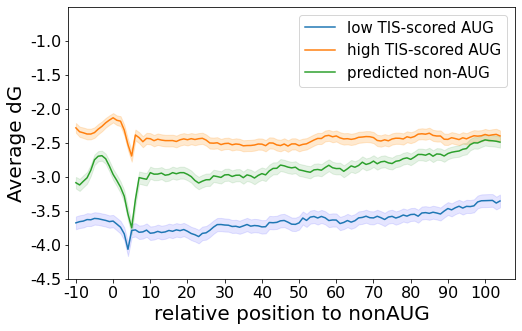

In [58]:
fig, ax = plt.subplots(figsize=(8,5))

mean_li = np.array(mean_and_cf_dG['mean'].tolist())
mean_li2 = np.array(mean_and_cf_dG2['mean'].tolist())
mean_li3 = np.array(mean_and_cf_dG3['mean'].tolist())

x = mean_and_cf_dG['relative position to START'].tolist()

ax.plot(x, mean_li, label='low TIS-scored AUG')
ax.plot(x, mean_li2, label='high TIS-scored AUG')
ax.plot(x, mean_li3, label='predicted non-AUG')

ci = np.array(mean_and_cf_dG['cf_diff'].tolist())
ci2 = np.array(mean_and_cf_dG2['cf_diff'].tolist())
ci3 = np.array(mean_and_cf_dG3['cf_diff'].tolist())

ax.fill_between(x, (mean_li-ci), (mean_li+ci), color='blue', alpha=.1)
ax.fill_between(x, (mean_li2-ci2), (mean_li2+ci2), color='darkorange', alpha=.19)
ax.fill_between(x, (mean_li3-ci3), (mean_li3+ci3), color='green', alpha=.1)

ax.set_xlim(-12, 108)
ax.set_xticks([-10,  0]+list(range(10, 108, 10)))
ax.set_xticklabels([-10,  0]+list(range(10, 108, 10)), fontsize=16)

ax.set_yticks(np.arange(-5, -0.5, 0.5))
ax.set_yticklabels([np.round(x, 1) for x in np.arange(-5, -0.5, 0.5)], fontsize=16)

ax.set_ylabel('Average dG', fontsize=20)
ax.set_xlabel('relative position to nonAUG', fontsize=20)

# ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=12)
ax.legend(loc='upper right', fontsize=15)



plt.ylim(-4.5, -0.5)

plt.savefig('RiboSET_ext_mRNA_secondary_structure_CF', format='svg', dpi=1200, bbox_inches="tight")

plt.show()

# Distribution of start codon types 

In [60]:
RiboSET_EXT_cds_cov_nonzero['codon_type'] = [x.split(';')[0] for x in RiboSET_EXT_cds_cov_nonzero['Riboseq_Summary'].tolist()]

RiboSET_EXT_cds_cov_nonzero['codon_position'] = [int(x.split('; ')[1].split('-')[0]) for x in RiboSET_EXT_cds_cov_nonzero['Riboseq_Summary'].tolist()]

barplot = RiboSET_EXT_cds_cov_nonzero[['codon_type', 'codon_position']].groupby('codon_type').count().reset_index().sort_values(by='codon_position')

barplot.columns = ['codon', 'counts']

barplot['codon'] = [x.replace('T', 'U') for x in barplot['codon'].tolist()]

barplot[barplot['codon'] != 'AUG']

,codon,counts
3,AUA,74
5,AUU,158
4,AUC,184
0,AAG,243
1,ACG,302
8,UUG,309
2,AGG,431
7,GUG,672
6,CUG,1078


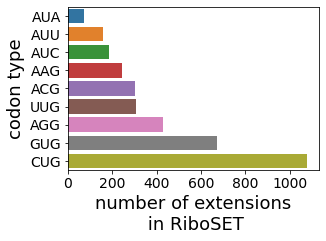

In [64]:
ax, fig = plt.subplots(figsize=(4.5, 3))

# sns.despine(left = True, bottom = True)

ax = sns.barplot(y="codon", x="counts", 
                 data=barplot[barplot['codon'] != 'AUG'])

ax.set_yticklabels(barplot[barplot['codon'] != 'AUG'].codon.tolist(), fontsize=14)

ax.set_xticks(list(range(0, 1100, 200)))
ax.set_xticklabels(list(range(0, 1100, 200)), fontsize=14)

ax.set_ylabel('codon type', fontsize = 18)

ax.set_xlabel('number of extensions\n in RiboSET', fontsize = 18)

plt.show()

# TIS scores 

In [65]:
# only in-frame starts 

def get_TIS(CODONli, ntermstart, trseq):
    '''
    extract 
    '''
    TIS_d = {}
    
    if len(CODONli) != 0:
        for codon_pos in CODONli:
            tr_pos = ntermstart + 3*codon_pos 
            TIS = trseq[tr_pos-4:tr_pos+4].replace('T', 'U')
            TIS_d[tr_pos] = TIS
            
    return TIS_d

In [80]:
R_Set = RiboSET_EXT_cds_cov_nonzero.copy()

In [81]:
li = []

for i, el in enumerate(meta[['tr_id', 'N_term_start1', 'N_term_end1']].merge(metadata_pc_g25[['tr_id', 'transcript_seq', 'gene']]).to_numpy()):
    
    if i % 1000 == 0:
        print (i)
    tr_id = el[0]
    ntermstart = el[1]
    nternend = el[2]
    type_ = 'ALL'
    trseq = el[3]
    
    if (tr_id in RiboSET_EXT_cds_cov_nonzero.tr_id.tolist()):
        flag = 'RiboSET_EXT'
    #elif tr_id in P_Set.tr_id.tolist():
        #flag = 'PhyloSET'
    else:
        flag = 'general'

    
    
    # sequence of theoretical NTE 
    primary_seq = trseq[ntermstart:nternend]
    gene =  el[-1]
    
    
    # split sequence of primary extension into triplets 
    primary_seq = [primary_seq[i:i+3] for i in range(0, len(primary_seq), 3)]

    # find all ner-cognate codons and their context, and their start positions: should be between nstart and nend
    CTG = np.where(np.array(primary_seq) == 'CTG')[0]
    ATG = np.where(np.array(primary_seq) == 'ATG')[0]
    GTG = np.where(np.array(primary_seq) == 'GTG')[0] 
    TTG = np.where(np.array(primary_seq) == 'TTG')[0]
    ATA = np.where(np.array(primary_seq) == 'ATA')[0] 
    ATT = np.where(np.array(primary_seq) == 'ATT')[0] 
    ACG = np.where(np.array(primary_seq) == 'ACG')[0] 
    ATC = np.where(np.array(primary_seq) == 'ATC')[0] 
    AAG = np.where(np.array(primary_seq) == 'AAG')[0]  
    AGG = np.where(np.array(primary_seq) == 'AGG')[0] 
    
    for CODONli in [ATG, CTG, GTG, TTG, ATA, ATT, ACG, ATC, AAG, AGG]:
        TIS_d = get_TIS(CODONli, ntermstart, trseq)
        for tr_pos, TIS in TIS_d.items():
            codon = trseq[tr_pos:tr_pos+3]
            if TIS_d[tr_pos] is not '': # e.g. ENST00000400907.6 AAG 2
                #print (tr_id, codon, tr_pos, TIS_d[tr_pos])
                
                # we also need to add context of cdsAUG for each transcript 
                cdsAUG_TIS = trseq[nternend-4:nternend+4].replace('T', 'U')
                cdsAUG_TIS_ext = trseq[nternend-6:nternend+5].replace('T', 'U')
                
                try:
                    codon_type = R_Set[R_Set['tr_id'] == tr_id].iloc[0].codon_type
                    codon_position = R_Set[R_Set['tr_id'] == tr_id].iloc[0].codon_position
                    if (tr_id in R_Set.tr_id.tolist()) & (tr_pos == codon_position-1) & (codon == codon_type):
                        flag2 = 'RiboSET_ext_pred'
                    elif (tr_id in R_Set.tr_id.tolist()):
                        flag2 = 'RiboSET_ext_remaining'
                    else:
                        flag2 = None
                    
                except:
                    codon_type = None
                    codon_position = None
                    flag2 = None
                
                
                
                
                #print (cdsAUG_TIS_ext)
                
                
                # get score for TIS. some in-frame upstream AUG might happen
                if TIS_d[tr_pos] in TIS_efficiency_dict:
                    TISscore = TIS_efficiency_dict[TIS_d[tr_pos]]                
                    TISscore_scaled = TIS_efficiency_dict_scaled[TIS_d[tr_pos]]
                else:
                    TISscore = None
                    TISscore_scaled = None
                
                if cdsAUG_TIS_ext in TIS_AUG_eff_dict:
                    TISscore_AUG = TIS_AUG_eff_dict[cdsAUG_TIS_ext]
                    TISscore_AUG_scaled = TIS_AUG_eff_dict_scaled[cdsAUG_TIS_ext]
                    
                    #print (TISscore_AUG_scaled)
                else:
                    TISscore_AUG = None
                    TISscore_AUG_scaled = None
                    
                
                li.append([tr_id, codon, tr_pos, TIS_d[tr_pos], 
                           cdsAUG_TIS, TISscore, gene, cdsAUG_TIS_ext, 
                           TISscore_AUG, TISscore_scaled,  TISscore_AUG_scaled, 
                           type_, flag, flag2])
            
            # there might be a situation when there is no 4nt before start => discard such cases 
        
        
    
TISdf = pd.DataFrame(li, columns = ['tr_id', 'codon', 'pos_of_codon', 'TIS', 'cdsAUG_TIS', 
                                    'TIS_score', 'gene', 'cdsAUG_TIS_ext', 'TISscore_AUG', 
                                    'TISscore_scaled', 'TISscore_AUG_scaled', 'type', 'flag', 'flag2'])

print (TISdf.shape)

TISdf[0:2]

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
(301719, 14)


,tr_id,codon,pos_of_codon,TIS,cdsAUG_TIS,TIS_score,gene,cdsAUG_TIS_ext,TISscore_AUG,TISscore_scaled,TISscore_AUG_scaled,type,flag,flag2
0,ENST00000624431.1,ATT,304,AAAGAUUG,AAAGAUGA,3.3,FO538757.2,GGAAAGAUGAG,76.0,0.065476,0.506667,ALL,general,None
1,ENST00000624431.1,AAG,301,GGGAAAGA,AAAGAUGA,0.3,FO538757.2,GGAAAGAUGAG,76.0,0.005952,0.506667,ALL,general,None


In [82]:
TISdf['flag2'].unique()

array([None, 'RiboSET_ext_remaining', 'RiboSET_ext_pred'], dtype=object)

In [83]:
TISdf

,tr_id,codon,pos_of_codon,TIS,cdsAUG_TIS,TIS_score,gene,cdsAUG_TIS_ext,TISscore_AUG,TISscore_scaled,TISscore_AUG_scaled,type,flag,flag2
0,ENST00000624431.1,ATT,304,AAAGAUUG,AAAGAUGA,3.3,FO538757.2,GGAAAGAUGAG,76.0,0.065476,0.506667,ALL,general,None
1,ENST00000624431.1,AAG,301,GGGAAAGA,AAAGAUGA,0.3,FO538757.2,GGAAAGAUGAG,76.0,0.005952,0.506667,ALL,general,None
2,ENST00000624431.1,AAG,313,AGGAAAGA,AAAGAUGA,0.3,FO538757.2,GGAAAGAUGAG,76.0,0.005952,0.506667,ALL,general,None
3,ENST00000624431.1,AGG,289,AACCAGGC,AAAGAUGA,0.2,FO538757.2,GGAAAGAUGAG,76.0,0.003968,0.506667,ALL,general,None
4,ENST00000624431.1,AGG,295,GCAUAGGG,AAAGAUGA,0.2,FO538757.2,GGAAAGAUGAG,76.0,0.003968,0.506667,ALL,general,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301714,ENST00000244174.10_PAR_Y,GTG,176,ACUUGUGA,UGUGAUGG,0.3,IL9R,CUUGUGAUGGG,97.0,0.005952,0.646667,ALL,general,None
301715,ENST00000244174.10_PAR_Y,TTG,134,AUAGUUGG,UGUGAUGG,0.3,IL9R,CUUGUGAUGGG,97.0,0.005952,0.646667,ALL,general,None
301716,ENST00000369423.7_PAR_Y,TTG,32,CAGGUUGG,GGGGAUGC,3.0,IL9R,UUGGGGAUGCC,68.0,0.059524,0.453333,ALL,general,None
301717,ENST00000369423.7_PAR_Y,ATC,20,ACAAAUCA,GGGGAUGC,0.4,IL9R,UUGGGGAUGCC,68.0,0.007937,0.453333,ALL,general,None


/home/alla/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/alla/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


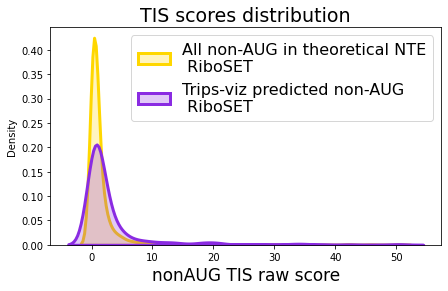

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(7,4))

#ax = sns.distplot(TISdf[TISdf['flag'] == 'general'].TIS_score.tolist(), 
#                  hist=False, 
#                  label = 'All non-AUG in theoretical NTE')


ax = sns.distplot(TISdf[TISdf['flag2'] == 'RiboSET_ext_remaining'].TIS_score.tolist(), 
                  hist=False, 
                  label = 'All non-AUG in theoretical NTE\n RiboSET',
                 kde_kws = {'shade': True, 'linewidth': 3},
                 color = 'gold')


#ax = sns.distplot(TISdf[TISdf['flag'] == 'PhyloSET'].TIS_score.tolist(), 
#                  hist=False, 
#                  label = 'All non-AUG in theoretical NTE\n PhyloSET',
#                 kde_kws = {'shade': True, 'linewidth': 3},
#                 color = 'forestgreen')


ax = sns.distplot(TISdf[TISdf['flag2'] == 'RiboSET_ext_pred'].TIS_score.tolist(), 
                  hist=False, 
                  label = 'Trips-viz predicted non-AUG\n RiboSET',
                 kde_kws = {'shade': True, 'linewidth': 3},
                 color = 'blueviolet')


#ax.set_xticks(range(0, 60, 10))
#ax.set_xticklabels(list(range(0, 60, 10)), fontsize=17)

#ax.set_yticks(np.arange(0, 0.5, 0.1))
#ax.set_yticklabels([np.round(x, 1) for x in np.arange(0, 0.5, 0.1)], fontsize=17)

ax.set_xlabel('nonAUG TIS raw score', fontsize=17)

ax.set_title('TIS scores distribution', fontsize=19)

plt.legend(prop={'size': 16})

plt.show()

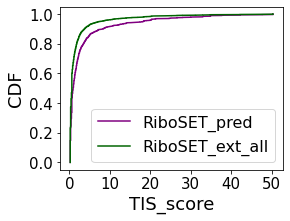

In [87]:
fig, ax = plt.subplots(1, figsize=(4,3))

def cdf(x):
    x, y = sorted(x), np.arange(len(x)) / len(x)
    return x, y


#x,y = cdf(b['TIS_score'].tolist())
#ax.plot(x,y, color='darkgoldenrod', label = 'PhyloSET')

x,y = cdf([x for x in TISdf[TISdf['flag2'] == 'RiboSET_ext_pred'].TIS_score.tolist() if str(x) != 'nan'])
ax.plot(x,y, color='purple', label = 'RiboSET_pred')

x,y = cdf([x for x in TISdf[TISdf['flag2'] == 'RiboSET_ext_remaining'].TIS_score.tolist() if str(x) != 'nan'])
ax.plot(x,y, color='darkgreen', label = 'RiboSET_ext_all')

ax.set_xticks(list(range(0, 51, 10)))
ax.set_xticklabels(list(range(0, 51, 10)), fontsize=15)

ax.set_yticks(np.arange(0, 1.1, 0.2))
ax.set_yticklabels([np.round(x, 2) for x in np.arange(0, 1.1, 0.2)], fontsize=15)

plt.legend(prop={'size': 16})

ax.set_xlabel('TIS_score', fontsize=18)

ax.set_ylabel('CDF', fontsize=18)

plt.show()

In [90]:
from scipy.stats import ks_2samp
import numpy as np 

ks_2samp(TISdf[TISdf['flag2'] == 'RiboSET_ext_pred'].TIS_score.tolist(),
        TISdf[TISdf['flag2'] == 'RiboSET_ext_remaining'].TIS_score.tolist())

KstestResult(statistic=0.16353225997527898, pvalue=6.216125474345194e-68)

# Sequence Logo context 

In [91]:
fasta = open('EXT_TIS_Riboseq_pred.fasta', 'w')

for el in TISdf[(TISdf['flag2'] == 'RiboSET_ext_pred') & 
      (TISdf['codon'] != 'ATG') & (TISdf['codon'] != 'AUG')][['tr_id', 'codon', 'pos_of_codon', 'TIS']].to_numpy():
    fasta.write('>'+el[0]+'_'+el[1]+'_'+str(el[2])+'\n')
    fasta.write(el[3].replace('T', 'U')+'\n')
    
    
fasta.close()